In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG','DBC','VTI','^VIX']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_55712\1997288386.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2000-01-01', '2021-01-04')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        VTI   ^VIX
Date                                              
2006-02-06  56.471348  20.889496  44.654274  13.04
2006-02-07  56.431892  20.285255  44.219494  13.59
2006-02-08  56.403687  20.198935  44.537628  12.83
2006-02-09  56.437546  20.388838  44.452797  13.12
2006-02-10  56.319138  20.017660  44.544697  12.87
Data covers 3753 trading days with 4 assets.


In [3]:
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = smoothed_prices.pct_change().dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-18  1.000000  1.000000  1.000000  1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130
2006-04-20  0.999555  1.003226  1.001815  0.993875
2006-04-21  0.999332  1.005552  1.002683  0.991806
2006-04-24  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-19 -0.000214  0.001443  0.000798 -0.002870
2006-04-20 -0.000231  0.001780  0.001016 -0.003264
2006-04-21 -0.000223  0.002318  0.000866 -0.002082
2006-04-24 -0.000160  0.001688  0.000843 -0.002305
2006-04-25 -0.000185  0.002115  0.000737 -0.001889


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.apply_volatility_scaling(target_volatility=target_volatility,rolling_window = 50)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Returns:
        - Scaled weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)
        asset_volatilities = asset_volatilities.dropna()
        
        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")
        
        return self.weights  # Return the scaled weights


In [5]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Preprocess the training data
    normalized_data, _ = preprocess_data(train_data)

    # Get allocations from the model
    allocations = model.get_allocations(normalized_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [7]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

In [8]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    """
    Performs rolling validation with specified allocation strategy, using smoothed data for volatility scaling 
    and raw data for portfolio management.
    
    Parameters:
    - data: DataFrame of historical raw prices.
    - allocation_strategy: Function that computes portfolio allocations based on training data.
    - train_years: Number of years for the training period in each roll.
    - test_months: Number of months for the testing period in each roll.
    - initial_cash: Initial investment amount.

    Returns:
    - results: List of dictionaries with performance metrics for each roll.
    """
    results = []
    start_date = data.index[0]
    final_values = []
    while True:
        # Define training and testing windows
        train_end = start_date + pd.DateOffset(years=train_years)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=test_months)
        
        # Stop if testing period exceeds available data
        if test_end > data.index[-1]:
            break
        
        # Split data into train and test sets for this roll
        train_data = data.loc[start_date:train_end]
        test_data = data.loc[test_start:test_end]
        
        # Preprocess the training and testing data
        normalized_train, train_returns = preprocess_data(train_data)
        normalized_test, _ = preprocess_data(test_data)
        
        # Train the model and get allocations
        if allocation_strategy == train_and_rebalance_portfolio:
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=train_data)  # Raw data for portfolio
            final_allocations = allocation_strategy(training_portfolio, model=model)
        else:
            # Non-LSTM strategy (e.g., equal-weighted or mean-variance)
            final_allocations = allocation_strategy(train_returns if allocation_strategy == mean_variance_optimized_strategy else normalized_train)
        
        # Initialize the testing portfolio with final allocations
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=test_data)  # Raw data for portfolio management
        testing_portfolio.portfolio_history = []  # Clear history before starting new testing period
        testing_portfolio.rebalance(final_allocations)  # Initial rebalancing with smoothed volatility
        
        #Perform daily rebalancing for volatility scaling using smoothed data
        # if allocation_strategy == train_and_rebalance_portfolio:
        #     for date in test_data.index[1:]:  # Skip the first row since we initialized
        #         # Calculate volatility scaling with smoothed data
        #         volatility_scaled_weights = testing_portfolio.apply_volatility_scaling(target_volatility=0.1, rolling_window=50)
                
        #         # Rebalance portfolio with volatility-scaled weights
        #         testing_portfolio.rebalance(volatility_scaled_weights)
                
        #         # Update portfolio value using raw returns for accurate tracking
        #         testing_portfolio.update_portfolio_value(date)
        # else:
        #     # If using a non-LSTM strategy, calculate portfolio performance with raw data returns
        #     testing_portfolio.calculate_daily_returns()  # Track performance in testing period
        testing_portfolio.calculate_daily_returns()
        final_values.append(testing_portfolio.get_portfolio_value())
        # Calculate performance metrics for this roll
        metrics = calculate_metrics(testing_portfolio.portfolio_history)
        
        # Store results for this roll
        results.append({
            'train_period': (start_date, train_end),
            'test_period': (test_start, test_end),
            'metrics': metrics
        })
        
        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()
        
        # Move the start date forward for the next roll
        start_date = start_date + pd.DateOffset(months=test_months)
    
    return results, final_values


[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: -0.5561
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.6154
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.6831
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.7578
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -0.8397
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: -0.9283
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: -1.0132
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -1.0651
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -1.0519
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: -1.0229
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -1.0327
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: -1.0760
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: -1.1312
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: -1.1734
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 

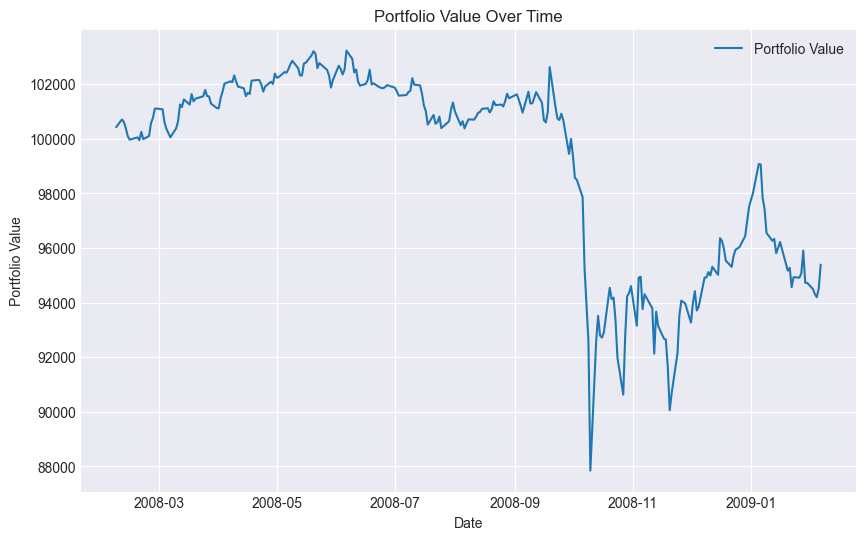

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -0.3179
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: -0.3311
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: -0.3409
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: -0.3484
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: -0.3544
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -0.3595
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: -0.3638
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.3674
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: -0.3702
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: -0.3722
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.3732
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: -0.3737
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: -0.3743
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -0.3753
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -0.3763
Epoc

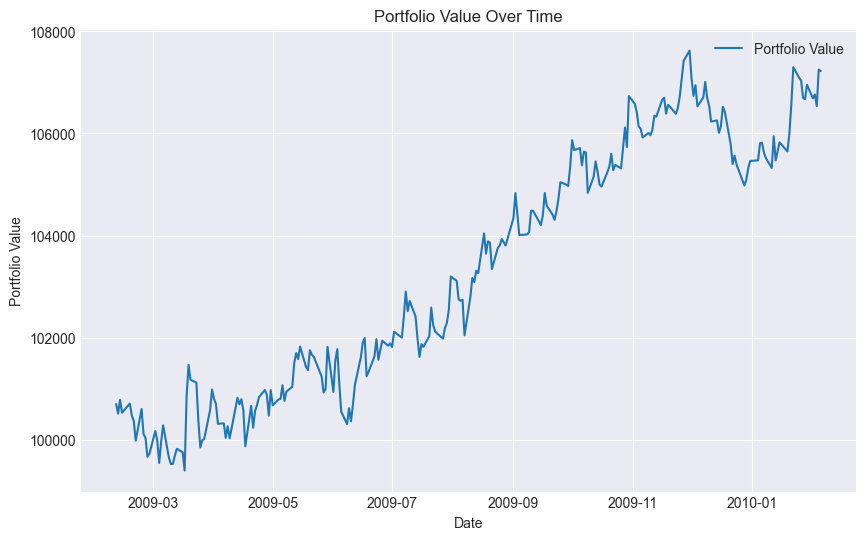

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1631
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1383
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1187
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1031
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0906
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0804
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0720
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0651
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0593
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0545
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0505
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0473
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0448
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0429
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0414
Epoch 16/100
1/1 ━━

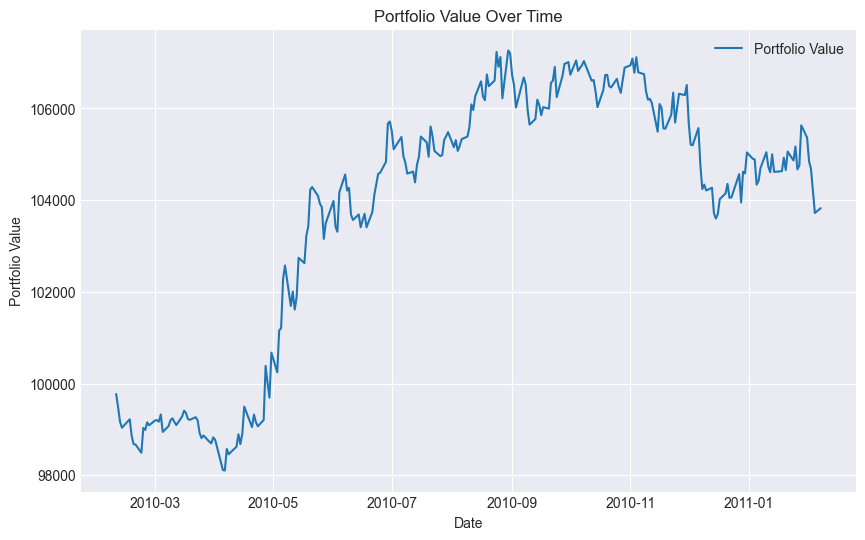

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -0.1205
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.2625
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: -0.4263
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: -0.5877
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: -0.7116
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -0.7825
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: -0.8147
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.8296
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.8398
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.8505
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: -0.8628
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: -0.8770
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.8928
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.9100
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: -0.9286
Epoc

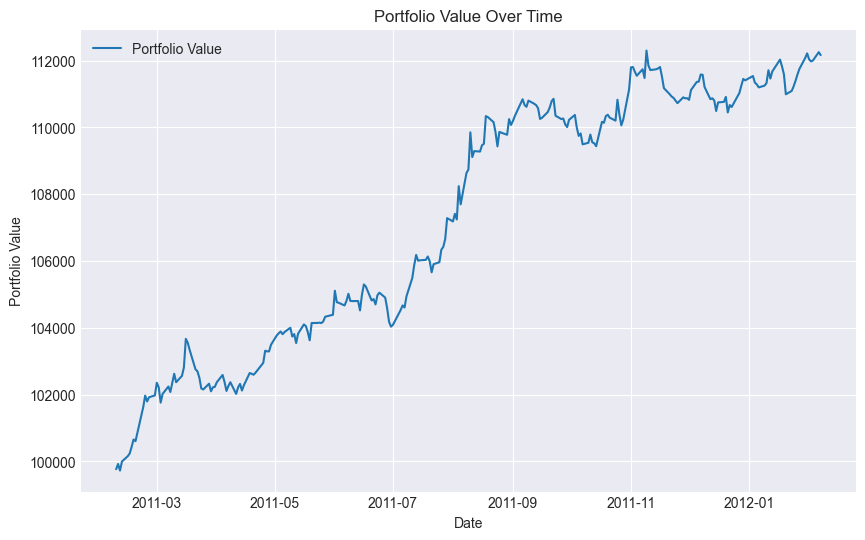

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: -0.2440
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: -0.2886
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.3408
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: -0.3918
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: -0.4241
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: -0.4301
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -0.4268
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.4288
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.4394
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: -0.4583
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.4838
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: -0.5137
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: -0.5445
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.5738
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: -0.6024
Epoc

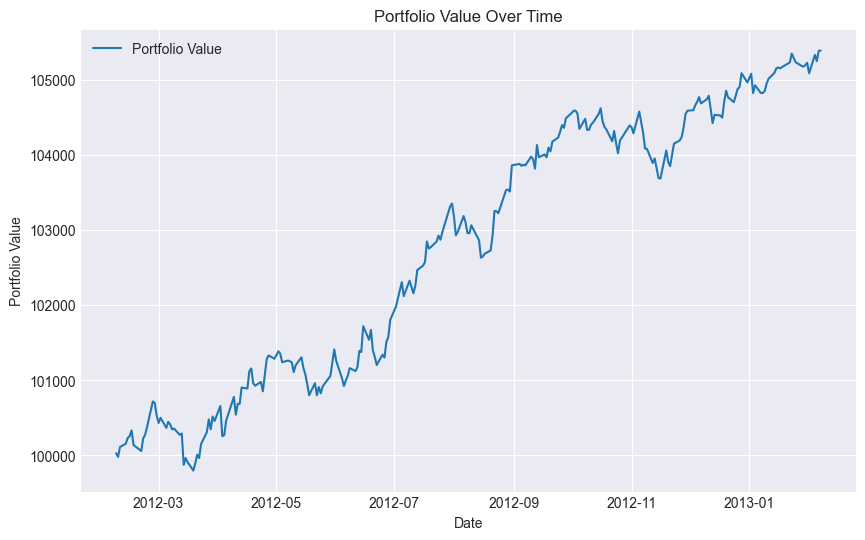

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.0048
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: -0.0160
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: -0.0293
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.0456
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -0.0660
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.0925
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: -0.1281
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: -0.1772
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -0.2457
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: -0.3362
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.4313
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.4908
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -0.5337
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: -0.6040
Epoch

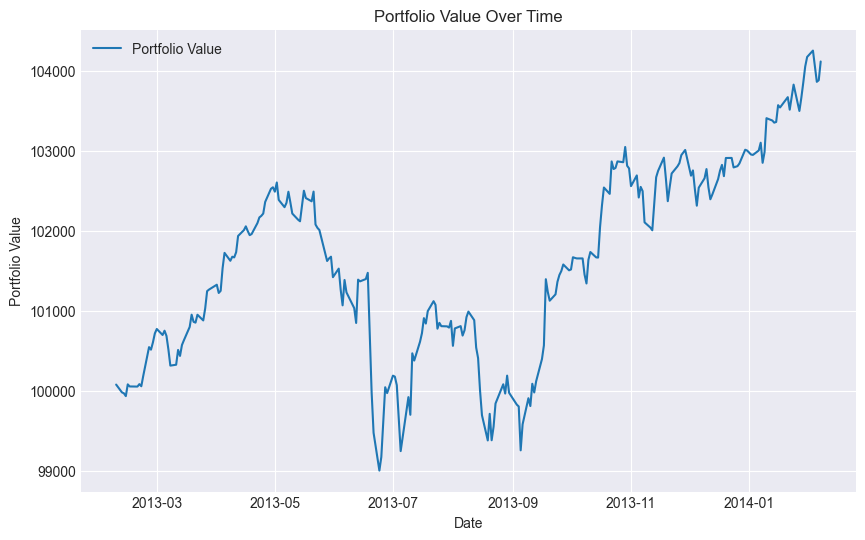

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -0.0738
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: -0.1414
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.2338
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: -0.3589
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: -0.5191
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: -0.6970
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -0.8440
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: -0.9190
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: -0.9425
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: -0.9497
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: -0.9543
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.9596
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.9665
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: -0.9752
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.9860
Epoc

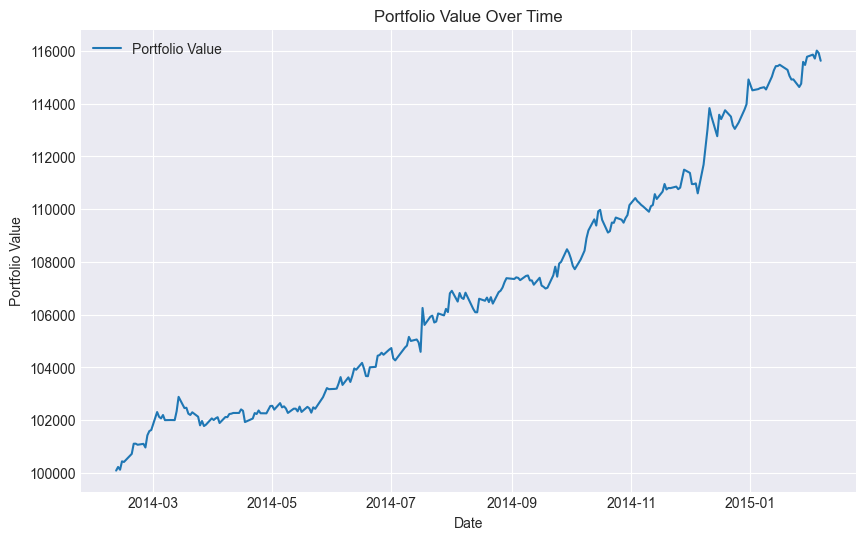

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: -0.1452
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: -0.1730
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: -0.2004
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: -0.2292
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.2614
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: -0.3000
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: -0.3487
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: -0.4123
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -0.4976
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.6148
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: -0.7781
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: -1.0057
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -1.3097
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -1.6514
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: -1.8769
Epoc

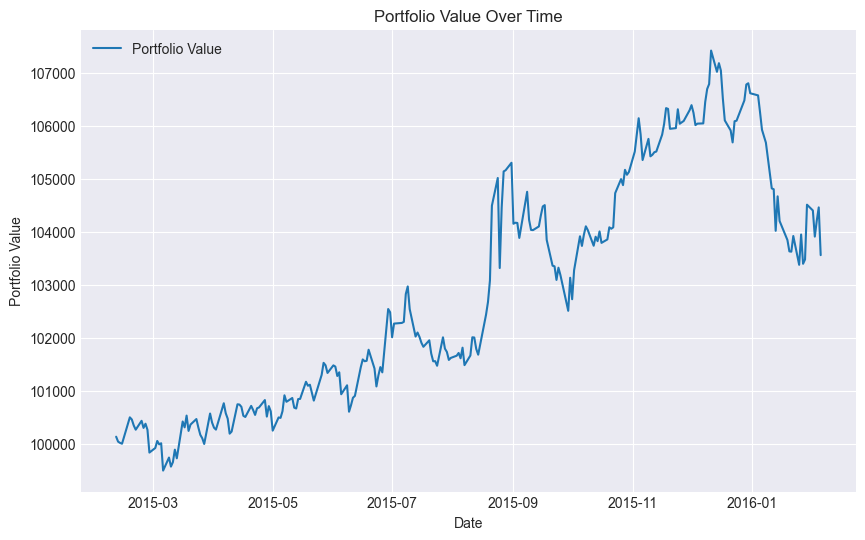

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -0.0540
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.0768
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.0947
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: -0.1090
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.1207
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.1307
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.1396
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: -0.1483
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -0.1577
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.1689
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: -0.1834
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: -0.2033
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.2321
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.2750
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.3396
Epoc

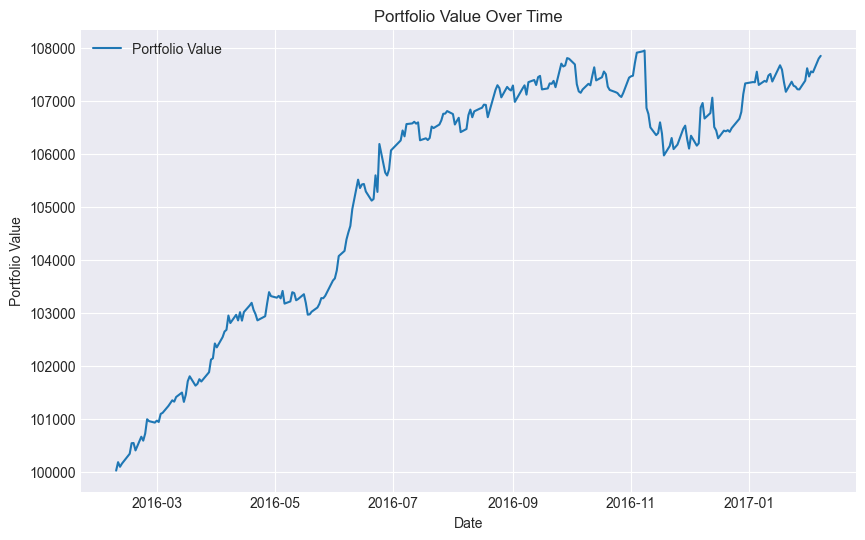

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0471
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0425
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0382
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0338
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0288
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0230
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0157
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0064
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: -0.0060
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.0231
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: -0.0478
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.0852
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: -0.1433
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.2281
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: -0.3154
Epoch 16/100

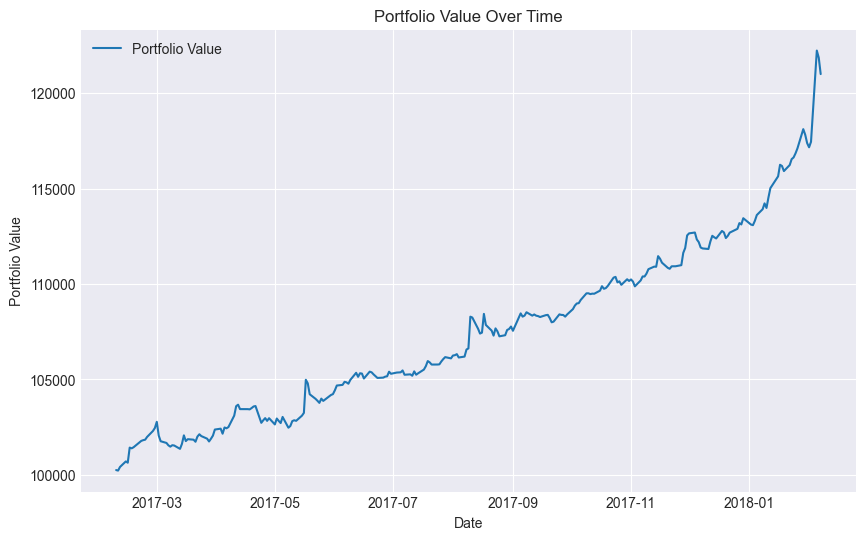

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: -0.2714
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: -0.3635
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.4643
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.5692
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.6727
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: -0.7702
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: -0.8629
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.9557
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -1.0518
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -1.1517
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -1.2523
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: -1.3469
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -1.4264
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: -1.4838
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: -1.5181
Epoc

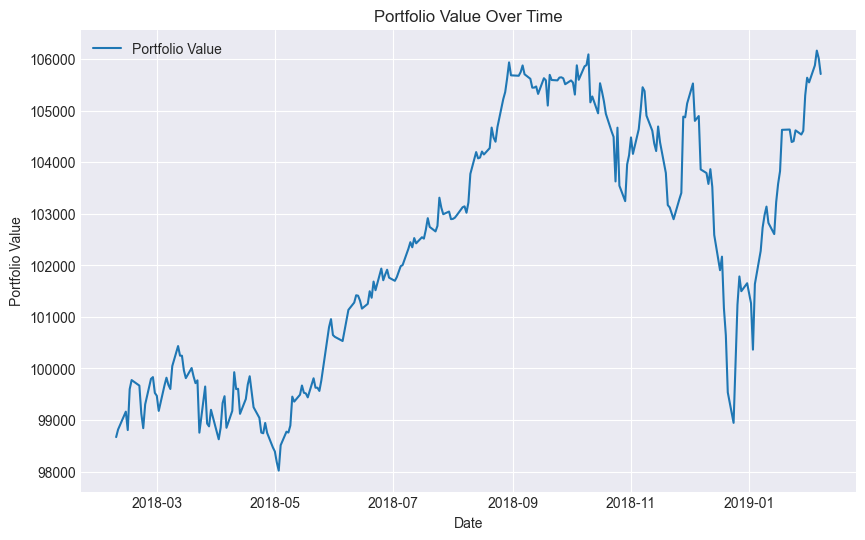

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: -0.2317
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: -0.2434
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.2569
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.2725
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.2906
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: -0.3117
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: -0.3364
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.3645
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: -0.3950
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: -0.4243
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -0.4473
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: -0.4603
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.4662
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.4709
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: -0.4779
Epoc

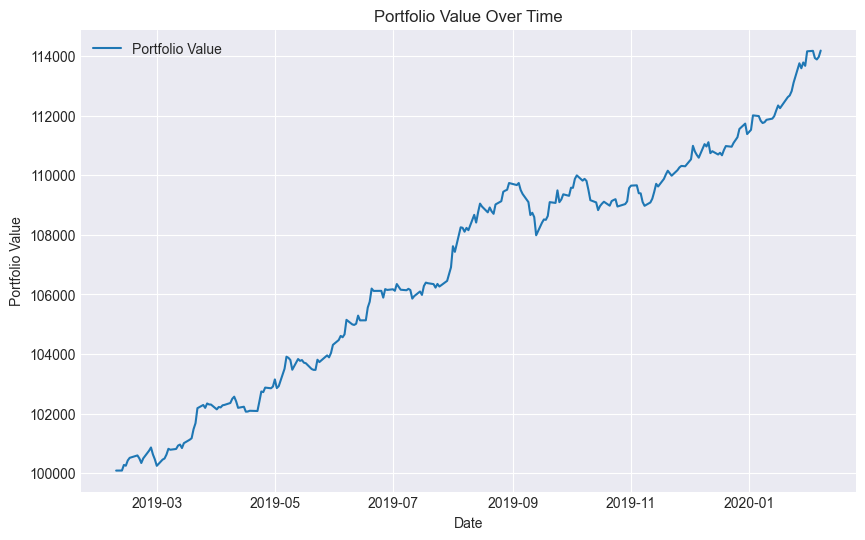

LSTM Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-06 00:00:00')), 'test_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2009-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': -0.3690614201193903, 'Sortino Ratio': -0.4528492154556496, 'Max Drawdown': 0.14897045534453893}}, {'train_period': (Timestamp('2007-02-06 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-07 00:00:00'), Timestamp('2010-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 1.1978825018301948, 'Sortino Ratio': 2.1666672349279255, 'Max Drawdown': 0.024564624252748836}}, {'train_period': (Timestamp('2008-02-06 00:00:00'), Timestamp('2010-02-06 00:00:00')), 'test_period': (Timestamp('2010-02-07 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.7441427746618404, 'Sortino Ratio': 1.3511137935505122, 'Max Drawdown': 0.03417034473353856}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-06 00:00:00')), 'test_p

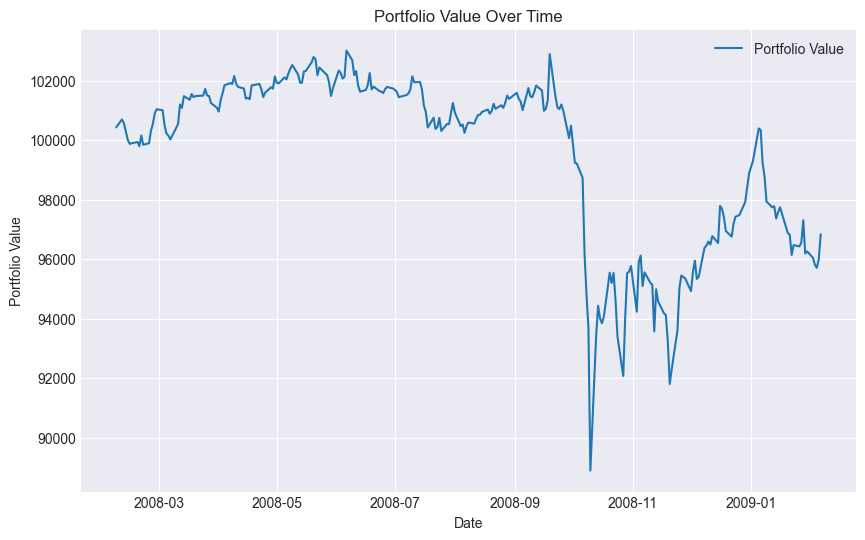

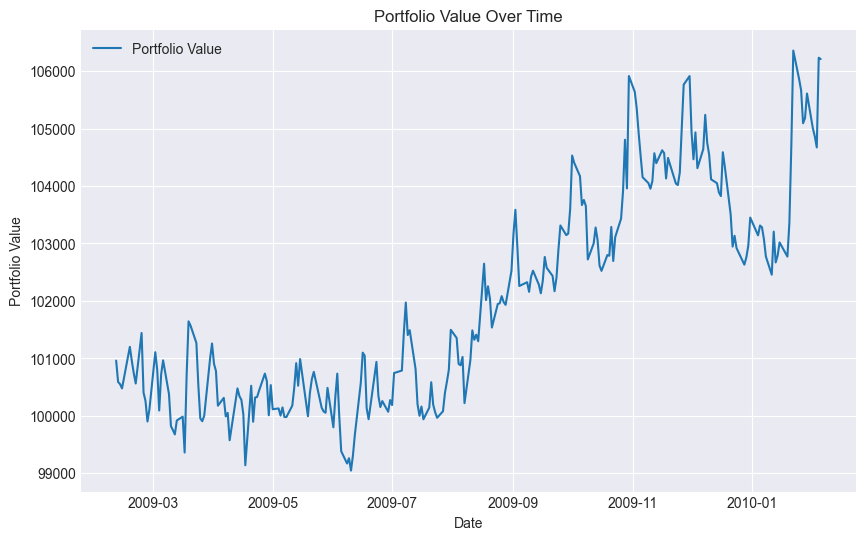

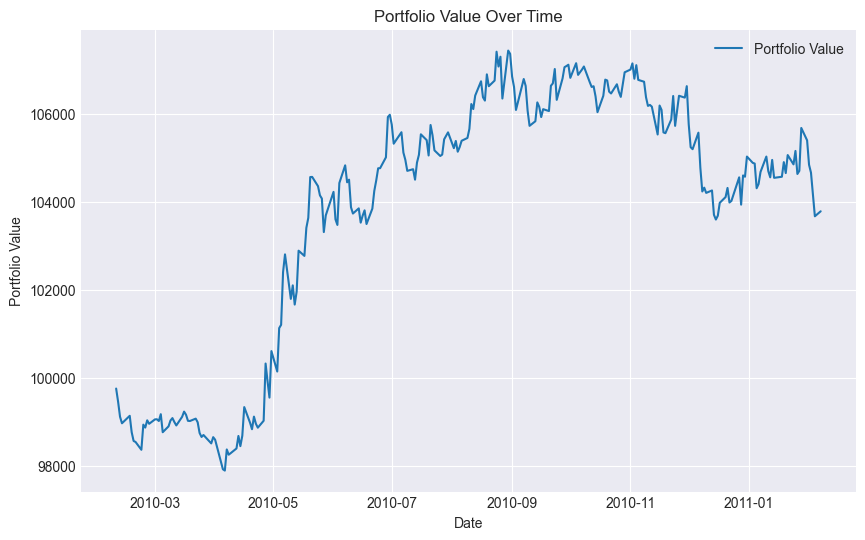

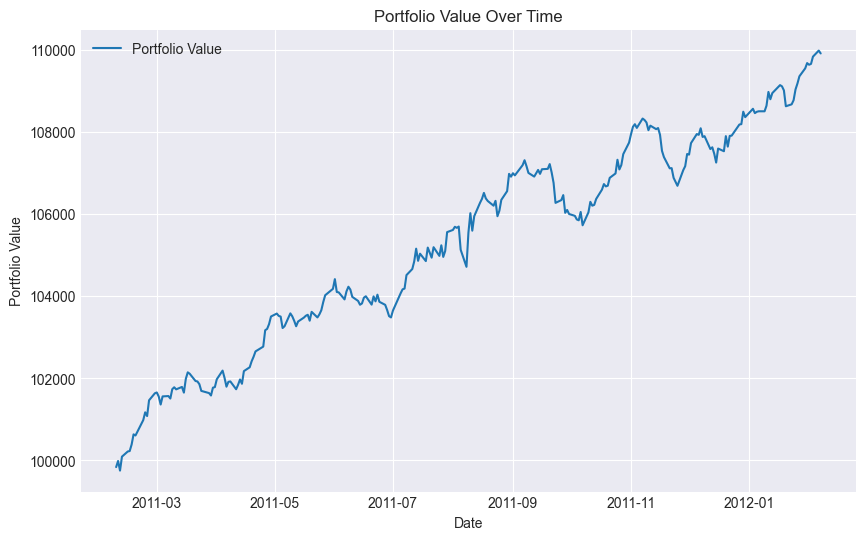

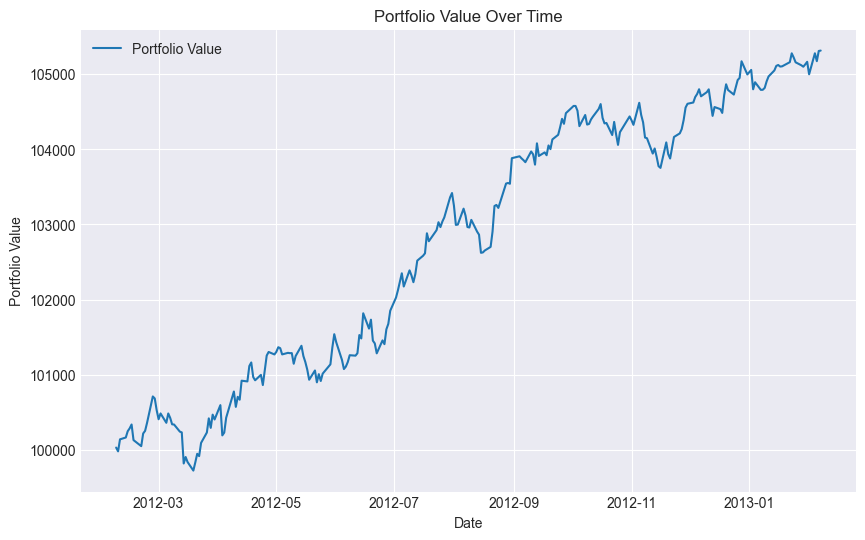

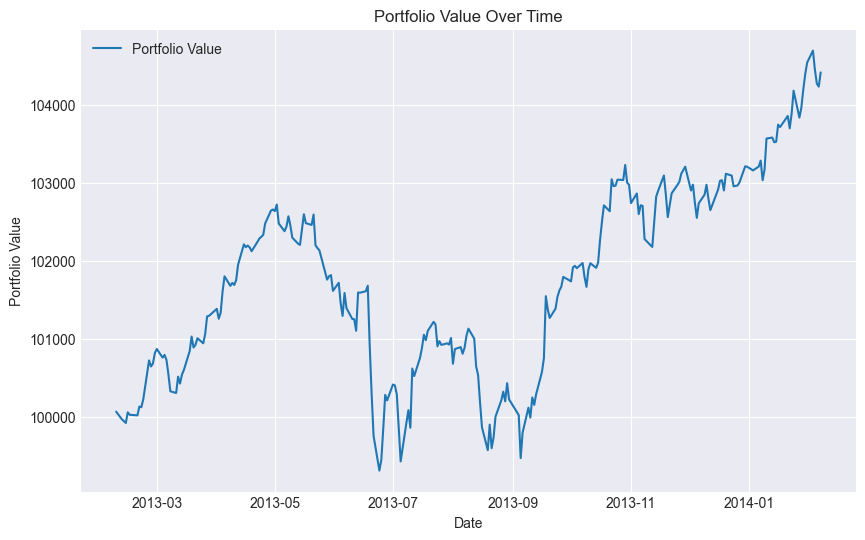

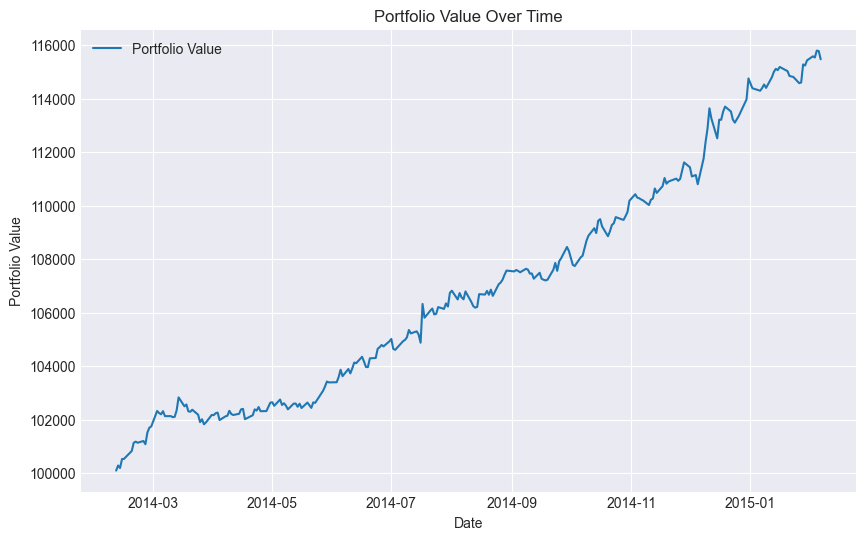

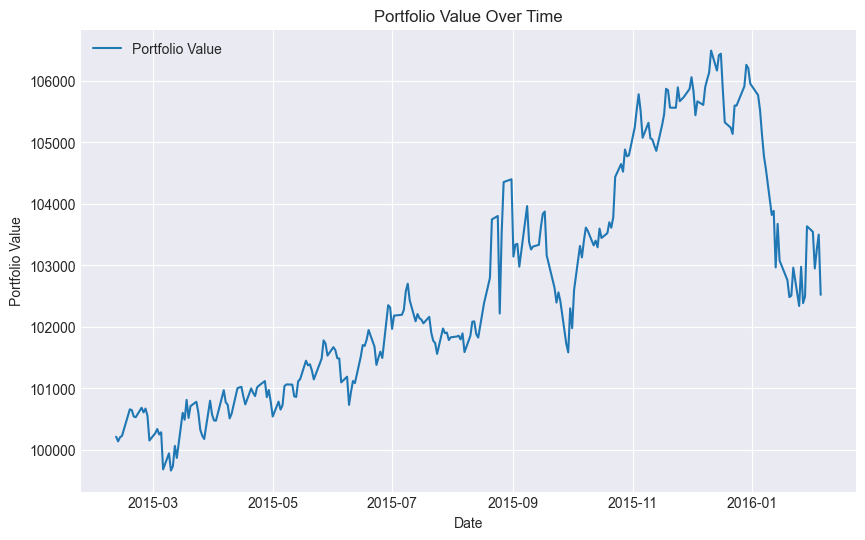

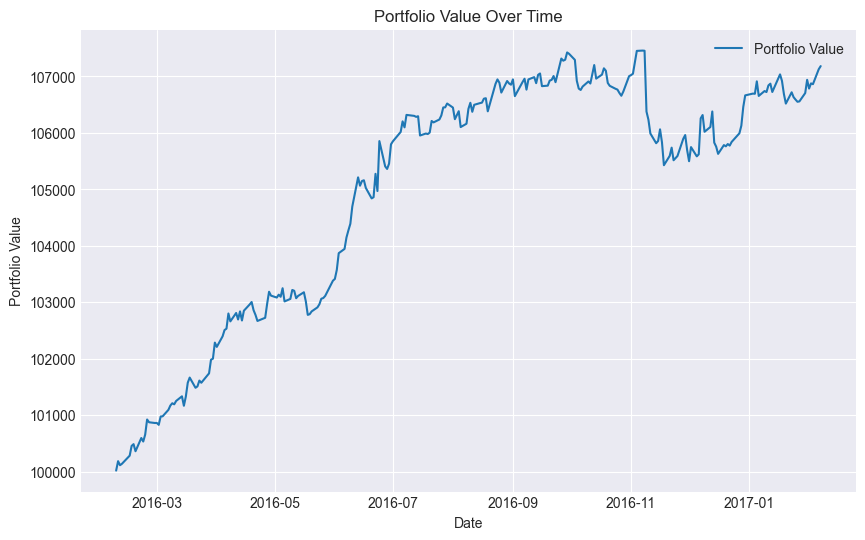

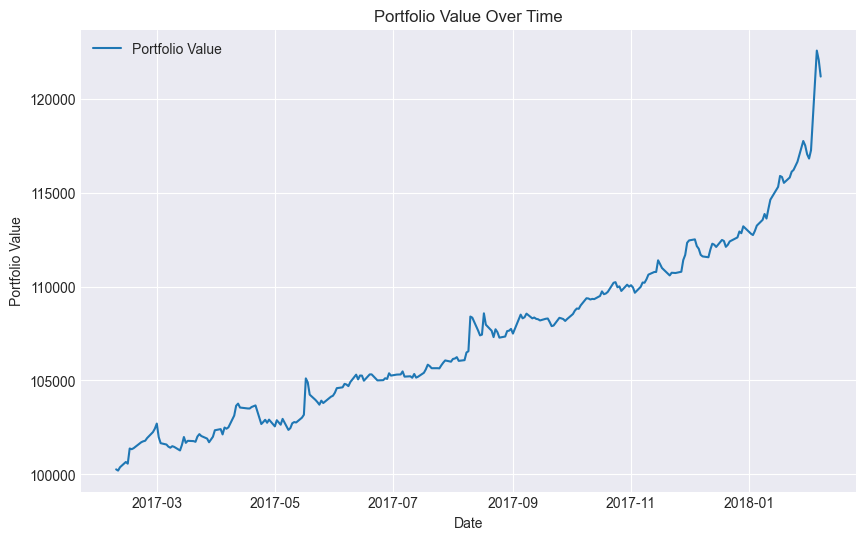

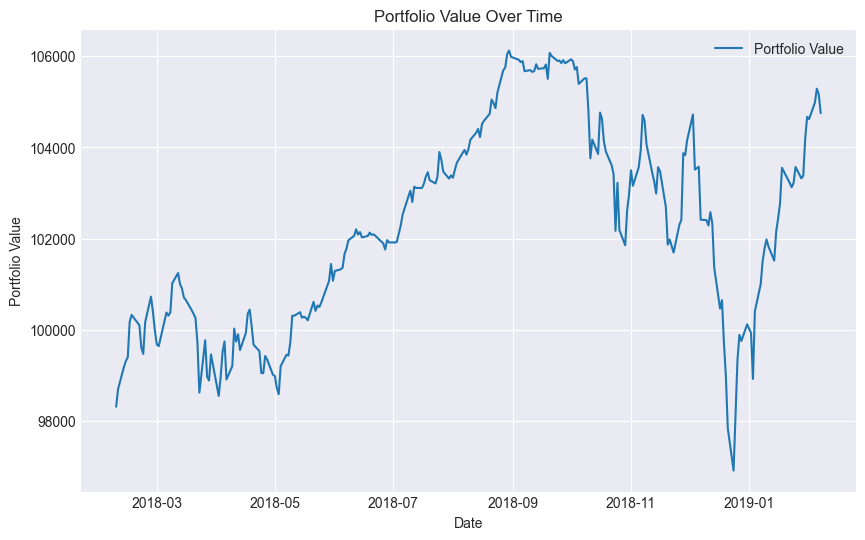

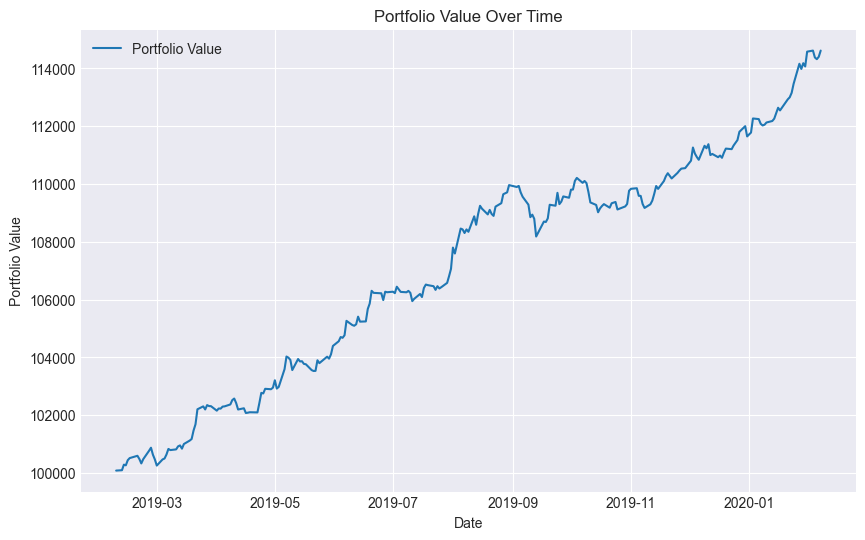

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-06 00:00:00')), 'test_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2009-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': -0.2632540201627108, 'Sortino Ratio': -0.31920499453612394, 'Max Drawdown': 0.13707336200351966}}, {'train_period': (Timestamp('2007-02-06 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-07 00:00:00'), Timestamp('2010-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.697513276910698, 'Sortino Ratio': 1.4100449878250716, 'Max Drawdown': 0.0326567443851839}}, {'train_period': (Timestamp('2008-02-06 00:00:00'), Timestamp('2010-02-06 00:00:00')), 'test_period': (Timestamp('2010-02-07 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'metrics': {'Sharpe Ratio': 0.6969718926429064, 'Sortino Ratio': 1.2752140398125351, 'Max Drawdown': 0.03574674454133853}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-06 

In [ ]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC','^VIX']
data = get_data(tickers, '2006-01-01', '2021-01-04')

# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results,lstm_values = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)
print("Final Portfolio Values:", lstm_values)
# Rolling validation with mean-variance optimization
mvo_results,mvo_values= generalized_rolling_validation(data, mean_variance_optimized_strategy)
print("Mean-Variance Optimization Results:", mvo_results)
print("Final Portfolio Values:", mvo_values)    


In [10]:
diff = [a - b for a, b in zip(lstm_values, mvo_values)]
print(diff)
print("Mean of the difference:", np.mean(diff))

[-1441.171769948749, 1012.5721639879339, 34.15086569197592, 2252.513310877868, 78.44251290861575, -296.23777432185307, 152.71056775811303, 1038.7726237953466, 663.5435921909084, -192.37865509762196, 962.3042100277235, -435.29373031819705]
Mean of the difference: 319.16065979600535
